## Imports

In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px # this is another plotting library for interactive plot

from sklearn.model_selection import train_test_split
from sklearn import metrics, manifold # we will use the metrics and manifold learning modules from scikit-learn
from pathlib import Path # to interact with file paths
from PIL import Image # to interact with images
from tqdm import tqdm # progress bar
from pprint import pprint # pretty print (useful for a more readable print of objects like lists or dictionaries)
from IPython.display import clear_output # to clear the output of the notebook

import torch
import torch.nn as nn
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import os
import shutil


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")

cuda


In [2]:
# CONTROL
num_channels = 1
SIZE = (32,32)
model_name = 'models/stop_line_estimator_advanced.pt'
onnx_model_path = "models/stop_line_estimator_advanced.onnx"
max_load = 250_000 #note: it will be ~50% more since training points with pure road gets flipped with inverted labels

## Load Pretrained Net and create Detector 

In [3]:
# # NETWORK ARCHITECTURE

# class StopLineEstimator(nn.Module):
#     def __init__(self, out_dim=4, channels=1): 
#         super().__init__()
#         ### Convoluational layers
#         self.conv = nn.Sequential( #in = (SIZE)
#             nn.Conv2d(channels, 8, kernel_size=5, stride=1), #out = 30
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=2, stride=2), #out=15
#             nn.BatchNorm2d(8),
#             nn.Conv2d(8, 4, kernel_size=5, stride=1), #out = 12
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=2, stride=1), #out=11
#             # nn.BatchNorm2d(4),
#             nn.Conv2d(4, 4, kernel_size=6, stride=1), #out = 6
#             nn.ReLU(True),
#         )
#         self.flat = nn.Flatten()
#         ### Linear sections
#         self.lin = nn.Sequential(
#             # First linear layer
#             nn.Linear(in_features=4*4*4, out_features=32),
#             nn.ReLU(True),
#             nn.Linear(in_features=32, out_features=out_dim),
#         )
        
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.flat(x)
#         x = self.lin(x)
#         return x

# stop_line_estimator = StopLineEstimator(out_dim=3,channels=num_channels).to(device)

In [4]:
# NETWORK ARCHITECTURE

class StopLineEstimator(nn.Module):
    def __init__(self, out_dim=4, channels=1): 
        super().__init__()
        ### Convoluational layers
        prob = 0.2
        self.conv = nn.Sequential( #in = (SIZE)
            nn.Conv2d(channels, 4, kernel_size=5, stride=1), #out = 28
            nn.ReLU(True),
            nn.Dropout(p=prob),
            nn.MaxPool2d(kernel_size=2, stride=2), #out=14
            nn.BatchNorm2d(4),
            nn.Dropout(p=prob),
            nn.Conv2d(4, 8, kernel_size=5, stride=1), #out = 10
            nn.ReLU(True),
            nn.Dropout(p=prob),
            nn.MaxPool2d(kernel_size=2, stride=2), #out=5
            nn.Dropout(p=prob),
            nn.Conv2d(8, 64, kernel_size=5, stride=1), #out = 1
            nn.ReLU(True),
        )
        self.flat = nn.Flatten()
        ### Linear sections
        self.lin = nn.Sequential(
            #normalize
            # nn.BatchNorm1d(3*3*4),
            # First linear layer
            nn.Linear(in_features=1*1*64, out_features=32),
            nn.ReLU(True),
            # nn.Linear(in_features=32, out_features=16),
            # nn.ReLU(True),
            # nn.Tanh(),
            nn.Linear(in_features=32, out_features=out_dim),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.lin(x)
        return x

stop_line_estimator = StopLineEstimator(out_dim=3,channels=num_channels).to(device)

In [5]:
# TEST NET INPUTS/OUTPUTS
#show the image with opencv
img = cv.imread('tests/test_img.jpg')
img = cv.resize(img, SIZE)
if num_channels == 1:
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = np.expand_dims(img, axis=2)
#convert to tensor
img = torch.from_numpy(img).float()
img = img.permute(2,0,1)
#add dimension
img = img.unsqueeze(0).to(device)
print(img.shape)

stop_line_estimator.eval()

# Inference
with torch.no_grad():
    output = stop_line_estimator(img)
    print(f'out shape: {output.shape}')

torch.Size([1, 1, 32, 32])
out shape: torch.Size([1, 3])


## Loading images and Labels

In [6]:
# IMG LOADER AND AUGMENTATION
import cv2 as cv
import numpy as np
from numpy.random import randint
from time import time, sleep



def load_and_augment_img(img, folder='training_imgs'):
    #convert to gray
    img = cv.resize(img, (4*SIZE[1], 4*SIZE[0]))

    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #create random ellipses to simulate light from the sun
    light = np.zeros(img.shape, dtype=np.uint8)
    #add ellipses
    for j in range(2):
        cent = (randint(0, img.shape[0]), randint(0, img.shape[1]))
        axes_length = (randint(10//4, 50//4), randint(50//4, 300//4))
        angle = randint(0, 360)
        light = cv.ellipse(light, cent, axes_length, angle, 0, 360, 255, -1)
    #create an image of random white and black pixels
    light = cv.blur(light, (50,50))
    noise = randint(0, 2, size=img.shape, dtype=np.uint8)*255
    light = cv.subtract(light, noise)
    light = np.clip(light, 0, 51)
    light *= 5
    #add light to the image
    img = cv.add(img, light)

    #blur the image
    img = cv.blur(img, (randint(1, 5), randint(1, 5)))

    # cut the top third of the image, 
    img = img[int(img.shape[0]*(2/5)):,:] ################################# 2/5 frame[int(frame.shape[0]*(2/5)):,:]

    #edges
    img = cv.resize(img, (2*SIZE[1], 2*SIZE[0]))

    # erosion and dilation
    r = randint(0, 5)
    if r == 0:
        #dilate
        kernel = np.ones((randint(1, 3), randint(1, 3)), np.uint8) #kernel = np.ones((randint(1, 5), randint(1, 5)), np.uint8)
        img = cv.dilate(img, kernel, iterations=1)
    elif r == 1:
        #erode
        kernel = np.ones((randint(1, 3), randint(1, 3)), np.uint8) #kernel = np.ones((randint(1, 5), randint(1, 5)), np.uint8)
        img = cv.erode(img, kernel, iterations=1)

    #edges    
    img = cv.Canny(img, 100, 200)

    #blur
    img = cv.blur(img, (3,3))

    #resize 
    img = cv.resize(img, SIZE)

    # #get max brightness
    # max_brightness = np.max(img)
    # ratio = 255.0/max_brightness
    # #normalize
    # img = (img*ratio).astype(np.uint8)

    # #add random tilt
    # max_offset = 1
    # offset = randint(-max_offset, max_offset)
    # img = np.roll(img, offset, axis=0)
    # if offset > 0:
    #     img[:offset, :] = 0 #randint(0,255)
    # elif offset < 0:
    #     img[offset:, :] = 0 # randint(0,255)
    
    #add noise 
    std = 60
    std = randint(1, std)
    noisem = randint(0, std, img.shape, dtype=np.uint8)
    img = cv.subtract(img, noisem)
    noisep = randint(0, std, img.shape, dtype=np.uint8)
    img = cv.add(img, noisep)

    return img



cv.namedWindow('img', cv.WINDOW_NORMAL)
# cv.setWindowProperty('img', cv.WND_PROP_FULLSCREEN, cv.WINDOW_FULLSCREEN)

for i in range(500):
    img = cv.imread(os.path.join('training_imgs', f'img_{i+1}.png'))
    img = load_and_augment_img(img)
    cv.imshow('img', img)
    key = cv.waitKey(100)
    if key == ord('q') or key == 27:
        break
cv.destroyAllWindows()

In [7]:
# DATASET CLASS
#TODO add negative examples: inside intersection, in normal road with high curvature
class CsvDataset(Dataset):
    def __init__(self, folder, transform=None, max_load=1000, channels=3):
        self.transform = transform
        self.folder = folder
        self.data = []
        self.channels = channels

        with open(folder+'/regression_labels.csv', 'r') as f:
            lines = f.read().split('\n')
            lines = lines[0:-1] #remove footer
            # Get x and y values from each line and append to self.data
            max_load = min(max_load, len(lines))
            self.all_imgs = torch.zeros((max_load, SIZE[1], SIZE[0], channels), dtype=torch.uint8)

            cv.namedWindow('img', cv.WINDOW_NORMAL)
            all_img_idx = 0
            for i in tqdm(range(200, max_load)): #start from 200 since first imgs have wrong labels
            # for i in range(max_load):
                #label
                line = lines[i]
                line = line.split(',')
                #x stopline, y stopline, yaw stopline
                label = np.array([float(line[4]), float(line[5]), float(line[6])], dtype=np.float32)
                dist_label = float(line[4]) #dist is used only to filter images
                
                MAX_DIST = 9.0
                #keep only small distanaces, avoid junctions
                if dist_label < MAX_DIST: #and not junction_imgs_mask[i]:  #if  dist_label < 0.6 and not junction_imgs_mask[i]: 
                    # print(f'Sample {i},  idx = {all_img_idx},  dist = {dist_label}')
                    # if dist_label < MIN_DIST:
                    #     dist_label = MAX_DIST+MIN_DIST  - dist_label
                    #img 
                    img = cv.imread(os.path.join(folder, f'img_{i+1}.png'))
                    img = load_and_augment_img(img)
                    if all_img_idx < 1000:
                        # cv.putText(img, f'{dist_label[0]:.2f}', (5,10), cv.FONT_HERSHEY_SIMPLEX, 0.3,255, 1)
                        # cv.putText(img, f'{np.rad2deg(angle_label[0]):.0f}', (5,25), cv.FONT_HERSHEY_SIMPLEX, 0.3,255, 1)
                        cv.imshow('img', img)
                        # print(label)
                        cv.waitKey(1)
                        if all_img_idx == 999:
                            cv.destroyAllWindows()
                    #add a dimension to the image
                    img = img[:, :,np.newaxis]
                    self.all_imgs[all_img_idx] = torch.from_numpy(img)
                    self.data.append(label)
                    
                    all_img_idx += 1
                else:
                    MAX_VISIBLE_DIST = 0.65
                    label[0] = MAX_VISIBLE_DIST
                    img = cv.imread(os.path.join(folder, f'img_{i+1}.png'))
                    img = load_and_augment_img(img)
                    if all_img_idx < 1000:
                        # cv.putText(img, f'{dist_label[0]:.2f}', (5,10), cv.FONT_HERSHEY_SIMPLEX, 0.3,255, 1)
                        # cv.putText(img, f'{np.rad2deg(angle_label[0]):.0f}', (5,25), cv.FONT_HERSHEY_SIMPLEX, 0.3,255, 1)
                        cv.imshow('img', img)
                        # print(label)
                        cv.waitKey(1)
                        if all_img_idx == 999:
                            cv.destroyAllWindows()
                    #add a dimension to the image
                    img = img[:, :,np.newaxis]
                    self.all_imgs[all_img_idx] = torch.from_numpy(img)
                    self.data.append(label)
                    
                    all_img_idx += 1

            self.all_imgs = self.all_imgs[:all_img_idx]
            self.data = np.array(self.data)

            print(f'\nall imgs: {self.all_imgs.shape}')
            print(f'data: {self.data.shape}')

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # img = read_image(os.path.join(self.folder, f'img_{idx+1}.png'))
        # img = img.float()
        img = self.all_imgs[idx]
        img = img.permute(2, 0, 1).float()
        value = self.data[idx]
        return img, value

In [8]:
#create dataset #takes a long time but then training is faster
train_dataset = CsvDataset('training_imgs', max_load=max_load, channels=num_channels)
#split dataset into train and val
train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

100%|██████████| 249800/249800 [09:25<00:00, 441.69it/s]



all imgs: torch.Size([249800, 32, 32, 1])
data: (249800, 3)


In [9]:
#data loader
train_dataloader = DataLoader(train_dataset, batch_size=8192, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=True)

In [10]:
#test dataloader
sample = next(iter(train_dataloader))
print(sample[0].shape)
print(sample[1].shape)

torch.Size([8192, 1, 32, 32])
torch.Size([8192, 3])


## Training

In [11]:
# TRAINING FUNCTION
def train_epoch(model, dataloader, regr_loss_fn, optimizer, L1_lambda=0.0, L2_lambda=0.0,  device=device):
    # Set the model to training mode
    model.train() #train
    # Initialize the loss
    pos_losses = []
    angle_losses = []

    # Loop over the training batches
    for (input, regr_label) in tqdm(dataloader):
        # Move the input and target data to the selected device
        input, regr_label =input.to(device), regr_label.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute the output
        output = model(input)

        #regression
        pos = output[:, 0:1]
        angle = output[:, 2]

        pos_label = regr_label[:, 0:1]
        angle_label = regr_label[:, 2]

        # Compute the losses
        pos_loss = 1.0*regr_loss_fn(pos, pos_label)
        angle_loss = 0*1.0*regr_loss_fn(angle, angle_label)
    
        #L1 regularization
        L1_norm = sum(p.abs().sum() for p in model.conv.parameters())
        L1_loss = L1_lambda * L1_norm 
        #L2 regularization
        L2_norm = sum(p.pow(2).sum() for p in model.conv.parameters())
        L2_loss = L2_lambda * L2_norm

        loss = pos_loss + angle_loss + L1_loss + L2_loss

        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()

        #batch loss
        pos_losses.append(pos_loss.detach().cpu().numpy())
        angle_losses.append(angle_loss.detach().cpu().numpy())

    return np.mean(pos_losses), np.mean(angle_losses)

# VALIDATION FUNCTION
def val_epoch(stop_line_estimator, val_dataloader, regr_loss_fn, device=device):
    stop_line_estimator.eval()
    pos_losses = []
    angle_losses = []
    for (input, regr_label) in tqdm(val_dataloader):
        input, regr_label =input.to(device), regr_label.to(device)
        output = stop_line_estimator(input)
        regr_out = output
        pos = regr_out[:, 0:1]
        angle = regr_out[:, 2]
        dist_label = regr_label[:, 0:1]
        angle_label = regr_label[:, 2]
        pos_loss = 1.0*regr_loss_fn(pos, dist_label)
        angle_loss = 1.0*regr_loss_fn(angle, angle_label)
        pos_losses.append(pos_loss.detach().cpu().numpy())
        angle_losses.append(angle_loss.detach().cpu().numpy())
    return np.mean(pos_losses), np.mean(angle_losses)

In [12]:
# TRAINING 
#parameters
lr = 0.003 #0.005
epochs = 500
#regularization is applied only to convolutional section, add weight decay to apply it to all layers
L1_lambda = 0*.1*9e-4 #0.001 
L2_lambda = 0*.1*1e-2 #2e-2
optimizer = torch.optim.Adam(stop_line_estimator.parameters(), lr=lr, weight_decay=9e-5) #wd = 2e-3# 3e-5
regr_loss_fn = nn.MSELoss()
best_val_loss = 100.0

for epoch in range(epochs):
    try:
    # if True:
        pos_loss, angle_loss = train_epoch(stop_line_estimator, train_dataloader, regr_loss_fn, optimizer, L1_lambda, L2_lambda, device)
        val_pos_loss, val_angle_loss = val_epoch(stop_line_estimator, val_dataloader, regr_loss_fn, device)
        clear_output(wait=True)
        print(f"Epoch  {epoch+1}/{epochs} \nPos loss: {pos_loss:.4f} --- val pos loss: {val_pos_loss:.4f}")
        print(f"angle loss: {np.rad2deg(angle_loss):.4f} --- val angle loss: {np.rad2deg(val_angle_loss):.4f}")
        if val_pos_loss < best_val_loss:
            best_val_loss = val_pos_loss
            torch.save(stop_line_estimator.state_dict(), model_name)
            print(f'Saved model ')
    except Exception as e:
        print(e)
        torch.cuda.empty_cache()
        continue
    

Epoch  51/500 
Pos loss: 0.0189 --- val pos loss: 0.0225
angle loss: 0.0000 --- val angle loss: 2.2626


 64%|██████▍   | 18/28 [00:09<00:05,  1.87it/s]


KeyboardInterrupt: 

In [13]:
# EVALUATE ON TEST SET (UNSEEN DATA)
stop_line_estimator.load_state_dict(torch.load(model_name))
print(f"Val pos_loss: {val_epoch(stop_line_estimator, val_dataloader, regr_loss_fn, device)}")

100%|██████████| 250/250 [00:00<00:00, 271.08it/s]

Val pos_loss: (0.022217076, 0.03951788)


(4, 1, 5, 5)
(8, 4, 5, 5)
(64, 8, 5, 5)


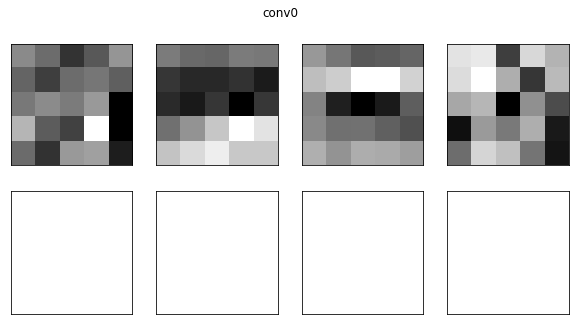

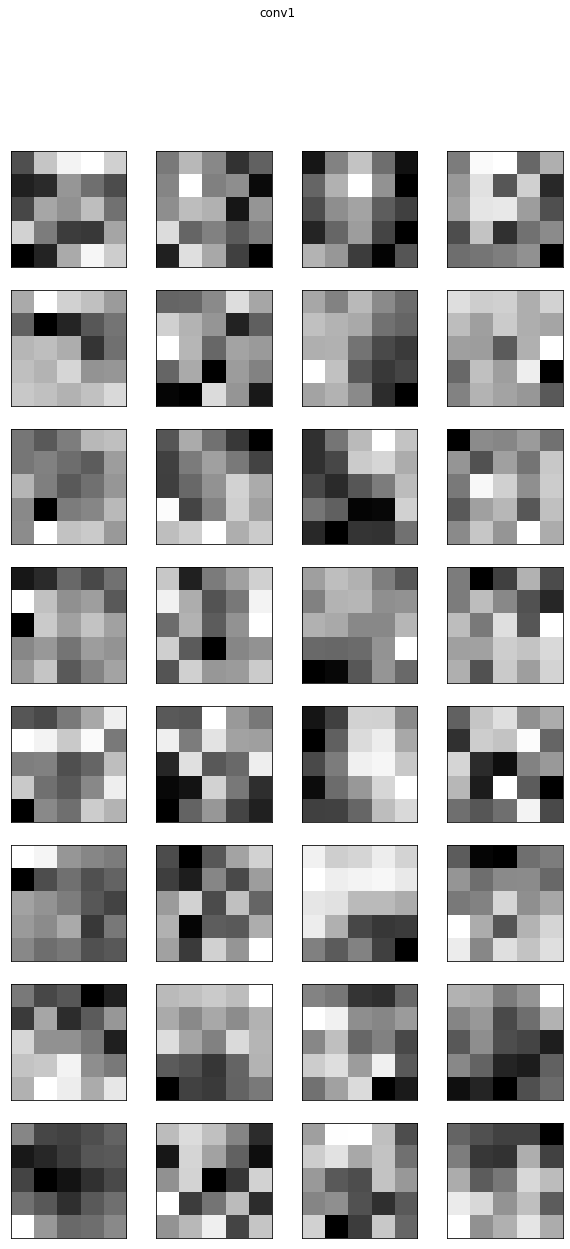

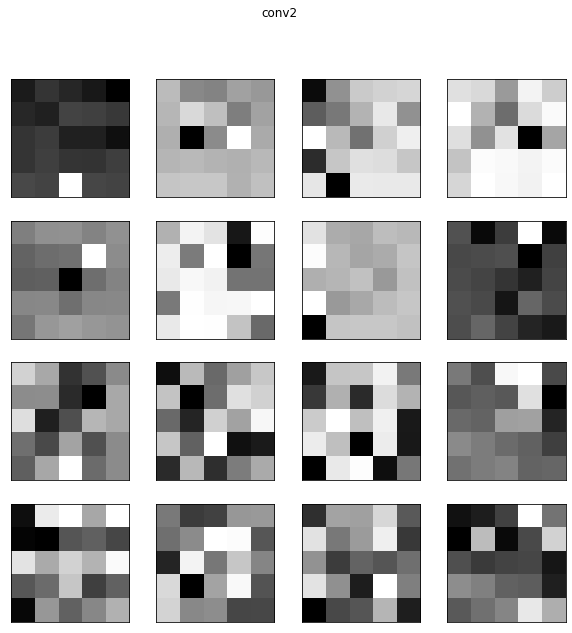

In [14]:
# VISUALIZE CONVOLUTIONAL FILTERS
conv_layers = []
children = list(stop_line_estimator.children())
for i in range(len(children)):
    if isinstance(children[i], nn.Conv2d):
        conv_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Conv2d):
                conv_layers.append(child)

c0 = conv_layers[0].weight.data.cpu().numpy()
c1 = conv_layers[1].weight.data.cpu().numpy()
c2 = conv_layers[2].weight.data.cpu().numpy()

def plot_nchw_data(data, h_num, v_num, title, size=(10, 10)):
    fig, axs = plt.subplots(h_num, v_num, figsize=size)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    return fig

# fig0 = plot_nchw_data(c0, 4, 4, 'conv0')
print(c0.shape)
print(c1.shape)
print(c2.shape)

fig0 = plot_nchw_data(c0, 2, 4, 'conv0', size=(10,5))

fig1 = plot_nchw_data(c1, 8, 4, 'conv1', size=(10,20)) 

fig2 = plot_nchw_data(c2, 4, 4, 'conv2', size=(10,10))



In [15]:
# CONVERT TO ONNX MODEL FOR OPENCV
stop_line_estimator.load_state_dict(torch.load(model_name))

#save the model so that opencv can load it
import torch
import torch.onnx
import torchvision
import torchvision.models as models
import sys

device = torch.device('cpu')
stop_line_estimator.to(device)

# set the model to inference mode
stop_line_estimator.eval()

# Create some sample input in the shape this model expects 
# This is needed because the convertion forward pass the network once 
dummy_input = torch.randn(1, num_channels, SIZE[1], SIZE[0])
torch.onnx.export(stop_line_estimator, dummy_input, onnx_model_path, verbose=True)

clear_output(wait=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
stop_line_estimator.to(device)

StopLineEstimator(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): Conv2d(8, 64, kernel_size=(5, 5), stride=(1, 1))
    (12): ReLU(inplace=True)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [16]:
# TEST WITH OPENCV
sample_image = "training_imgs/img_1.png"
images = [cv.imread(f"training_imgs/img_{i+1}.png") for i in range(100)]
 
#The Magic:
lk =  cv.dnn.readNetFromONNX(onnx_model_path)

avg_col = (0,0,0) if num_channels == 3 else 0

for i in tqdm(range(100)):
    image = images[i]
    image = cv.resize(image, SIZE)
    if num_channels == 1:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blob = cv.dnn.blobFromImage(image, 1.0, SIZE, avg_col, swapRB=True, crop=False)
    # print(blob.shape)
    lk.setInput(blob)
    preds = lk.forward()
    # print(f"Predictions: {preds[0][2]}")

print(f"Predictions: {preds}")
print(f"Predictions shape: {preds.shape}")

100%|██████████| 100/100 [00:00<00:00, 2486.69it/s]

Predictions: [[ 6.1105800e-01 -5.9140326e-33 -5.3395472e-33]]
Predictions shape: (1, 3)
